In [2]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import torch
from IPython.display import HTML, display
import glob as glob

from utils.diagnostics import compute_summary_statistics

plt.style.use('bmh')
plt.rcParams['lines.linewidth'] = 1

In [3]:
model_names = ["ew_lo", "mvo_ls", "md_ls", "dlpo_ls", "dlpo1_ls", "dlpo2_ls"]
stats_order = ["E[R]", "Std(R)", "Sharpe", "Sortino", "AvgDD", "MaxDD", "% Positive Ret."]

In [4]:
def aggregate_results(path):
    files = glob.glob(os.path.join(path, "*.csv"))

    all_summary = []
    for f in files:
        summary = pd.read_csv(f)

        all_summary.append(summary)
    
    all_summary_df = pd.concat(all_summary)
    all_summary_df.sort_values("date", inplace=True)

    return all_summary_df.reset_index(drop=True)

In [5]:
all_summary = []

for model in model_names:

        output_path = os.path.join(os.getcwd(),
                                   "data",
                                   "outputs",
                                   model)
    
        summary = aggregate_results(path=output_path)

        # compute pnl
        summary["pnl"] = summary["returns"] * summary["weights"]

        # add model name
        summary["model"] = model

        # save summary
        all_summary.append(summary)
all_summary_df = pd.concat(all_summary, axis=0)

## 1) Summary Statistics of the Portfolios

In [6]:

all_stats = {}
for model in model_names:

    portfolio_returns = torch.tensor(all_summary_df.loc[all_summary_df["model"] == model].groupby("date").sum()["pnl"])
    stats = compute_summary_statistics(portfolio_returns=portfolio_returns)

    all_stats[model] = stats
all_stats_df = pd.DataFrame(all_stats).T[stats_order]

display(HTML(all_stats_df.to_html()))

,E[R],Std(R),Sharpe,Sortino,AvgDD,MaxDD,% Positive Ret.
ew_lo,3.330121,19.500730,0.170769,0.203218,-11.416489,-64.134031,0.534799
mvo_ls,17.395756,81.623493,0.213122,0.762266,-20.131441,-60.063641,0.518180
md_ls,194.809719,3690.725213,0.052784,0.059042,-57.856718,-100.000000,0.523708
dlpo_ls,0.655855,8.009490,0.081885,0.114797,-15.110730,-32.625808,0.499468
dlpo1_ls,-0.126392,8.646736,-0.014617,-0.019843,-19.544050,-44.317915,0.508162
dlpo2_ls,-0.831536,6.421536,-0.129492,-0.128987,-12.678068,-28.664821,0.495854


In [8]:
print(all_stats_df.reset_index().to_latex(index=False))

\begin{tabular}{lrrrrrrr}
\toprule
   index &       E[R] &      Std(R) &    Sharpe &   Sortino &      AvgDD &       MaxDD &  \% Positive Ret. \\
\midrule
   ew\_lo &   3.330121 &   19.500730 &  0.170769 &  0.203218 & -11.416489 &  -64.134031 &         0.534799 \\
  mvo\_ls &  17.395756 &   81.623493 &  0.213122 &  0.762266 & -20.131441 &  -60.063641 &         0.518180 \\
   md\_ls & 194.809719 & 3690.725213 &  0.052784 &  0.059042 & -57.856718 & -100.000000 &         0.523708 \\
 dlpo\_ls &   0.655855 &    8.009490 &  0.081885 &  0.114797 & -15.110730 &  -32.625808 &         0.499468 \\
dlpo1\_ls &  -0.126392 &    8.646736 & -0.014617 & -0.019843 & -19.544050 &  -44.317915 &         0.508162 \\
dlpo2\_ls &  -0.831536 &    6.421536 & -0.129492 & -0.128987 & -12.678068 &  -28.664821 &         0.495854 \\
\bottomrule
\end{tabular}



## 2) Cummulative Returns of the Portfolios

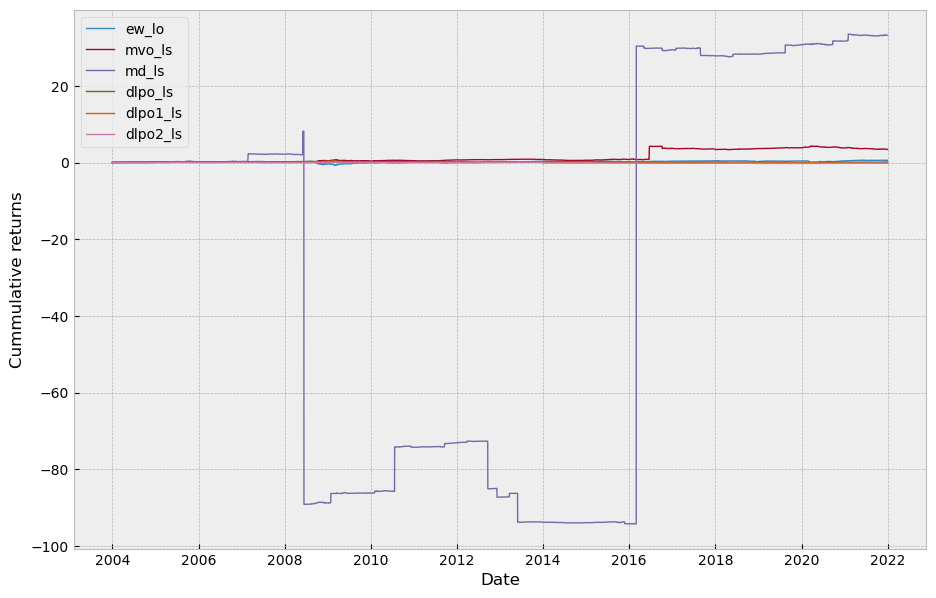

In [9]:

fig, ax = plt.subplots(figsize=(11, 7))
for model in model_names:
    summary_df = all_summary_df.loc[all_summary_df["model"] == model]
    cum_pnl_df = summary_df.groupby("date").sum()[["pnl"]].loc["2004-01-01":].cumsum().reset_index()
    ax.plot(pd.to_datetime(cum_pnl_df['date']), cum_pnl_df["pnl"], label=model)

plt.xlabel("Date")
plt.ylabel("Cummulative returns")
plt.legend(loc='best', fontsize=10)   
# fig.savefig('img/' + ticker + '_' + key1 + '_fs_methods.png')
plt.show()

## 3) Boxplot with the Sharpe Ratio for each Monte Carlo Sample

## 4) Forecast Comparison - Diebold-Mariano Test